In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image

#### Please change train or val

### Dataset Visualization

In [2]:
# Image path
img_num = "101"
slice_num = "048"

### Fixed Size Bounding Box

[0.0, 0.5087890625, 0.6142578125, 0.005859375, 0.005859375]
[0.0, 0.4580078125, 0.62890625, 0.005859375, 0.00390625]
[0.0, 0.5087890625, 0.6142578125, 0.005859375, 0.005859375]
[0.0, 0.4580078125, 0.62890625, 0.005859375, 0.00390625]
[0.0, 0.5087890625, 0.6142578125, 0.005859375, 0.005859375]
[0.0, 0.4580078125, 0.62890625, 0.005859375, 0.00390625]


/tmp/ipykernel_122923/4285585405.py:108: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


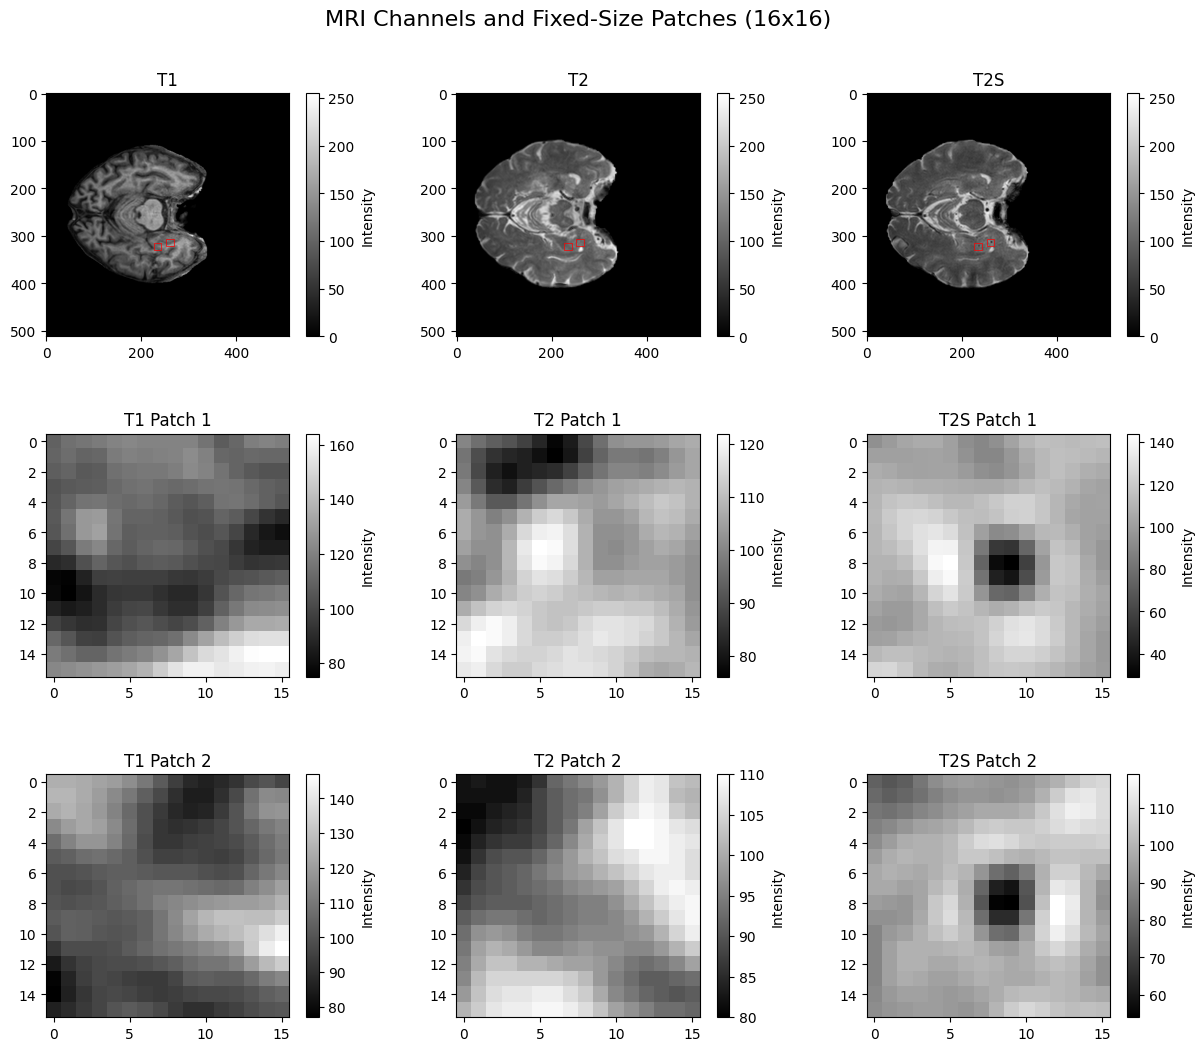

In [ ]:
def extract_fixed_size_patch(channel, center_x, center_y, patch_size=16):
    """
    Extract a fixed-size patch centered on the given coordinates
    """
    height, width = channel.shape
    half_size = patch_size // 2
    
    # Calculate patch boundaries
    x_min = int(center_x - half_size)
    y_min = int(center_y - half_size)
    x_max = int(center_x + half_size)
    y_max = int(center_y + half_size)
    
    # Handle edge cases
    if x_min < 0:
        x_max -= x_min  # Shift patch right
        x_min = 0
    if y_min < 0:
        y_max -= y_min  # Shift patch down
        y_min = 0
    if x_max > width:
        x_min -= (x_max - width)  # Shift patch left
        x_max = width
    if y_max > height:
        y_min -= (y_max - height)  # Shift patch up
        y_max = height
    
    return channel[y_min:y_max, x_min:x_max]

def plot_yolo_boxes_with_channel_patches(image_path, bboxes, patch_size=16):
    """
    Plot original channels and their 16x16 patches without overlap
    """
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"The image file does not exist: {image_path}")
    
    try:
        image = Image.open(image_path)
        image = np.array(image)
    except Exception as e:
        raise IOError(f"Error reading the image: {e}")
    
    if len(image.shape) == 2:
        image = np.stack((image,) * 3, axis=-1)
    
    height, width = image.shape[:2]
    n_boxes = len(bboxes)
    
    if n_boxes == 0:
        print("No bounding boxes found in the image.")
        return
        
    # Create figure with original image row plus one row per bbox
    fig = plt.figure(figsize=(15, 4 * (n_boxes + 1)))
    
    # Create GridSpec with n_boxes + 1 rows (1 for original images, rest for patches)
    gs = plt.GridSpec(n_boxes + 1, 3, figure=fig, hspace=0.4)
    
    # Channel names
    channel_names = ['T1', 'T2', 'T2S']
    
    # Plot each channel
    for channel_idx, channel_name in enumerate(channel_names):
        # Extract channel
        channel = image[:, :, channel_idx]
        
        # Plot full image in top row
        ax = fig.add_subplot(gs[0, channel_idx])
        # im = ax.imshow(channel, cmap='gray', vmin=0, vmax=255)
        im = ax.imshow(channel, cmap='gray')
        ax.set_title(f'{channel_name}')
        plt.colorbar(im, ax=ax, label='Intensity')
        
        # Draw all bounding boxes on original image
        for bbox in bboxes:
            print(bbox)
            class_id, x_center, y_center, _, _ = bbox
            center_x = int(x_center * width)
            center_y = int(y_center * height)
            
            # Draw fixed-size box
            half_size = patch_size // 2
            x_min = center_x - half_size
            y_min = center_y - half_size
            
            rect = plt.Rectangle((x_min, y_min), patch_size, patch_size,
                               linewidth=0.5, edgecolor='red', facecolor='none')
            ax.add_patch(rect)
        
        # Plot patches
        for box_idx, bbox in enumerate(bboxes):
            _, x_center, y_center, _, _ = bbox
            center_x = int(x_center * width)
            center_y = int(y_center * height)
            
            # Extract patch
            patch = extract_fixed_size_patch(channel, center_x, center_y, patch_size)
            
            # Create subplot for patch in its own row
            ax_patch = fig.add_subplot(gs[box_idx + 1, channel_idx])
            # im_patch = ax_patch.imshow(patch, cmap='gray', vmin=0, vmax=255)
            im_patch = ax_patch.imshow(patch, cmap='gray')
            ax_patch.set_title(f'{channel_name} Patch {box_idx + 1}')
            plt.colorbar(im_patch, ax=ax_patch, label='Intensity')
            ax_patch.axis('on')
    
    plt.suptitle('MRI Channels and Fixed-Size Patches (16x16)', fontsize=16, y=0.95)
    plt.tight_layout()
    plt.show()

def visualize_image_channels_and_patches(root_path, img_num, slice_num):
    """
    Visualize MRI channels and their patches with fixed-size boxes
    """
    label_path = f"{root_path}/labels/train/sub-{img_num}_slice_{slice_num}.txt"
    image_path = label_path.replace("labels", "images").replace("txt", "png")
    
    try:
        with open(label_path, 'r') as txt_file:
            bboxes = [list(map(float, line.split())) for line in txt_file.readlines()]
        
        plot_yolo_boxes_with_channel_patches(image_path, bboxes, patch_size=16)
        
    except Exception as e:
        print(f"An error occurred: {e}")
        try:
            with Image.open(image_path) as img:
                print(f"Image format: {img.format}")
                print(f"Image size: {img.size}")
                print(f"Image mode: {img.mode}")
        except Exception as e:
            print(f"Could not open the image for additional information: {e}")

# Usage
root_path = "/mnt/storage/ji/brain_mri_valdo_mayo/YOLO_valdo_stacked"
visualize_image_channels_and_patches(root_path, img_num, slice_num)